# Programming Assignment 4 (PA4): Gradient-Domain Copy Paste

### CS70 — Foundations of Applied Computer Science
---

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text (using Markdown). Please complete/extend this notebook for your homework submission:

* For any mathematical questions, make sure to **show you work**.
* For any questions that ask for code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use [Anaconda](https://www.anaconda.com/products/individual), specifically the version based on Python 3.8.

<div class="alert alert-warning">
Homework assignments in CS70 count towards your final grade and must therefore be done individually.
</div>

## Import statements

We provide the import statements required to complete the assignment in the following cell. 

<div class="alert alert-danger" role="alert">
    <b>Import policy:</b> You must not use any <code>import</code>'s other than the ones we provide.
</div>

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell in the Jupyter Notebook to include the required modules. It imports libraries such as NumPy and Matplotlib and configures them to produce nice graphics.
</div>

In [1]:
import numpy as np  # for building and manipulating matrices
import time  # for measuring time elapsed while running code

# for sparse matrix operations
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as sla
from skimage.transform import resize

# for graphics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# for interactive graph features
%matplotlib notebook  
%config InlineBackend.figure_format = 'retina'  # nice retina graphics

This assignment explores gradient-domain image processing, a simple technique with a broad set of applications including blending, tone-mapping, and non-photorealistic rendering. For the core project, we will focus on “Poisson blending".


You will be graded on the correctness, design, and efficiency of your code.


## Background
The primary goal of this assignment is to seamlessly blend an object or texture from a source image into a target image. The simplest method would be to just copy and paste the pixel values from one image directly into the other. Unfortunately, this will create very noticeable seams, even if the backgrounds are well-matched. How can we get rid of these seams without doing too much perceptual damage to the source region?

![](images/setup.png)

The insight is that our visual system is often more sensitive to the gradient of an image (how quickly the pixel values change left-right and up-down) than the overall intensity. We will therefore set up the problem as finding values for the pasted target pixels that maximally preserve the gradient of the source region without changing any of the background pixels. Note that we are making a deliberate decision here to ignore the overall intensity! So a green hat could turn red, but it will still look like a hat.

## 1D Problem - Fully Constrained
We will first consider a simplified 1D example.

Say we have the following image, and we want to paste it to a new region in the target image. Treat this as a 1D problem, where the bar colors correspond to the following: orange bars are pixels outside the mask, red bars are source pixels to be pasted, and blue bars are the boundary conditions.

![](images/1dproblem.png)

In order to solve this problem, you will find the gradients between the original values, write them as constraints, and then solve your system to find the copied values. You will create a system of 4 equations (constraints) and 4 unknowns ($t_{2}, . . . , t_{5}$) to solve this 1D problem. We use $t_{i}$ to refer to the solved value at location $i$ in the image on the right (the four "?" marks) and $s_{i}$ refers to the value in the source image on the left.

We will use finite differences to compute the image gradients. To enforce the gradient constraint, we’d like the differences between neighboring pixels in $t_{1}, . . . , t_{5}$ to match the differences between neighboring pixels in the source image $s_{1}, . . . , s_{5}$. We can express this as the following constraint equations:

$$
\begin{align*}
t2 − t1 &= s2 − s1 \qquad\text{(1)}\\
t3 − t2 &= s3 − s2 \qquad\text{(2)}\\
t4 − t3 &= s4 − s3 \qquad\text{(3)}\\
t5 − t4 &= s5 − s4 \qquad\text{(4)}\\
\end{align*}
$$

### Implementing the fully constrained solution

1. To help you plan your solution, write out the above constraints on paper in matrix-vector form as $A\mathbf{v} =\mathbf{b}$. You have $4$ unknowns and $4$ equations. What size should $A$ be? How about $\mathbf{v}$ *Hint: keep in mind what is known and not known.*
1. Implement your solution in `fully_constrained_1D` below.
    * Start by populating $A$ and $\mathbf{b}$ with your constraints.
    * Solve the system for the unknowns $\mathbf{v}$ using `np.linalg.solve`.
    * Put the solved values in the appropriate spots in a vector `fully_t` and return it from your function.

**Note:** You may start by formulating your solution for exactly $4$ unknowns and $4$ constraints. This will give you most of the credit. To get full credit, you should generalize it so that your function will work for $n$ unknowns and $n$ constraints without using any for loops.

In [264]:
# fully-constrained problem
def fully_constrained_1D(s, t):
    fully_t = np.zeros(t.shape)
    numUnknowns = np.count_nonzero(t == 0)
    # TODO: your code here
    
    # setting up b
    find_zeros = np.where(t==0)[0]
    b = np.array(s[find_zeros] - s[find_zeros-1])
    b[0] = b[0] + t[0]
    
    # making A
    A_matrix = np.zeros((numUnknowns, numUnknowns))
    A_matrix[np.arange(numUnknowns), np.arange(numUnknowns)] = np.ones(numUnknowns)
    A_matrix = A_matrix + np.diag(np.repeat(-1, numUnknowns - 1), -1)
    
    # putting solved values into appropiate spots 
    unknowns = np.linalg.solve(A_matrix, b)
    fully_t[0] = t[0]
    fully_t[t.shape[0]-1] = t[t.shape[0]-1]
    fully_t[1:t.shape[0]-1] = unknowns
        
    return fully_t

### Testing the fully-constrained solution

Test your implementation by completing the code fragment below.

It starts by initializing vectors `s` and `t` as in the images above (note that we have not included the values at index 0 or 7).
```python
s = np.array([3, 4, 3, 5, 4, 3]).T
t = np.array([6, 0, 0, 0, 0, 1]).T
```
It then creates a figure and plots the source and target vectors as two separate bar graphs (using `plt.subplots`, and `.bar`). It also sets a title for each subplot so we know what each one corresponds to.

The code also calls your fully constrained solver. Visualize the results with `.bar` in another subplot. Make sure to add a descriptive title. Check Matplotlib's [.bar documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html), or simply run `help(plt.bar)` to get additional details.

Notice that the gradients have been preserved, but the right boundary does not match up smoothly. We include the expected numerical result as `expected_fully_t`.

<IPython.core.display.Javascript object>


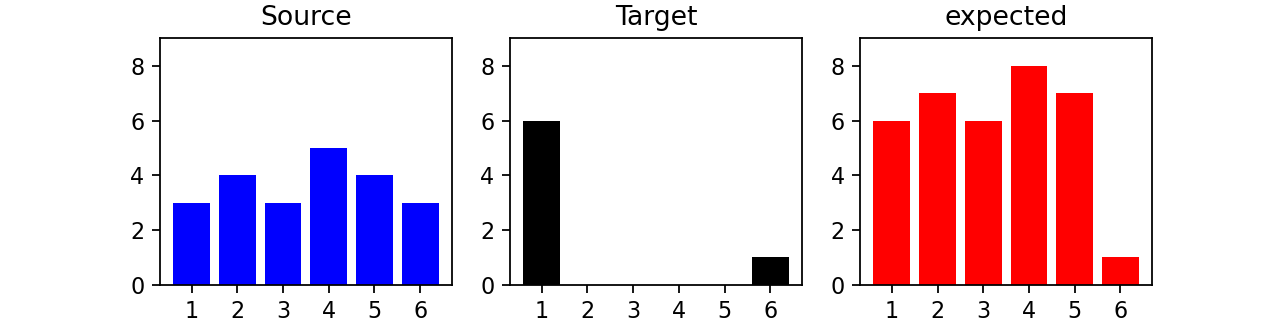

4
[6. 7. 6. 8. 7. 1.]
Sum of absolute differences is 0.0


In [265]:
# visualizing 1D solutions
s = np.array([3, 4, 3, 5, 4, 3]).T
t = np.array([6, 0, 0, 0, 0, 1]).T

# the expected result
expected_fully_t = np.array([6, 7, 6, 8, 7, 1])

# set up a new figure
fig, axs = plt.subplots(1,3)
# fig.tight_layout(pad=0.0)
fig.set_size_inches(8,2)
ymax = max(max(s),max(t))+3
width = np.arange(1,len(s)+1)

# plot the source and target graphs as subplots
axs[0].bar(width,s,color='b')
axs[0].set_ylim(0,ymax)
axs[0].set_title('Source')
axs[0].set_xticks(width)

axs[1].bar(width,t,color='k')
axs[1].set_title('Target')
axs[1].set_ylim(0,ymax)
axs[1].set_xticks(width)

# compute the fully constrained solutions
fully_t = fully_constrained_1D(s, t)
print(fully_t)

print(f"Sum of absolute differences is {np.sum(np.abs(fully_t-expected_fully_t))}")

# 
# TODO: add one more subplot with your solution here
axs[2].bar(width,fully_t,color='r')
axs[2].set_ylim(0,ymax)
axs[2].set_title('expected')
axs[2].set_xticks(width)

plt.show()

## 1D Problem - Least Squares

We will add in another constraint for this last gradient. Since there is now a 5th constraint but still 4 unknowns, we have an overconstrained system of equations, and we will solve it with least-squares.

The equations will enforce the gradient constraints:

$$
\begin{align*}
t2−t1 &= s2−s1 \qquad\text{(5)}\\
t3−t2 &= s3−s2 \qquad\text{(6)}\\
t4−t3 &= s4−s3 \qquad\text{(7)}\\
t5−t4 &= s5−s4 \qquad\text{(8)}\\
t6−t5 &= s6−s5 \qquad\text{(9)}\\
\end{align*}
$$

### Implementing the least-squares solution

1. To help you plan your solution, write out the above equations on paper as an over-constrained system in standard matrix form, $\lVert A\mathbf{v} - \mathbf{b} \rVert ^{2}$. You have $4$ unknowns and $5$ equations. What size should $A$ be? How about $\mathbf{b}$? *Hint: again, keep in mind what is known and not known.*
1. Now, implement the function `least_squares_1D` below. As before, this function should take the source and target vectors, `s` and `t`, but it will now compute the over-constrained solution for the missing elements of `t`. In `least_squares_1D`:
  * Populate your constraints into a matrix `A` and vector `b`.
  * Solve the system for the unknowns `v`. You may use `np.linalg.lstsq`, or you can form the normal equations and use `np.linalg.solve`. Do not use `np.linalg.inv`.
  * Put the solved values in the appropriate spots in a vector `ls_t`, and return it from your function.

**Note:** Again, you may start by formulating your solution for exactly $4$ unknowns and $5$ constraints. This will give you most of the credit. To get full credit, you should generalize it so that your function will work for $n$ unknowns and $n+1$ constraints without using any for loops.

In [266]:
# least-squares version
def least_squares_1D(s, t):
    # TODO: your code here
    ls_t = np.zeros(t.shape)
    numUnknowns = np.count_nonzero(t == 0)


    # setting up b
    find_zeros = np.where(t==0)[0]
    b = np.array(s[find_zeros] - s[find_zeros-1])
    b[0] = b[0] + t[0]
    
    last_value = t[find_zeros[-1] + 1]
    last_row = s[find_zeros[-1]+1]-s[find_zeros[-1]]-last_value
    b = np.append(b, last_row)
    
    # setting up A
    A_matrix_shape_calc = t.shape[0]
    A_matrix = np.zeros((t.shape[0]-1, t.shape[0]-1))
    
    first_row = np.concatenate((np.array([1]), np.zeros(t.shape[0]- 2)))
    A_matrix[0] = first_row

    # making the difference matrix
    A_matrix = np.zeros((numUnknowns, numUnknowns))
    A_matrix[np.arange(numUnknowns), np.arange(numUnknowns)] = np.ones(numUnknowns)
    A_matrix = A_matrix + np.diag(np.repeat(-1, numUnknowns - 1), -1)
    A_matrix = np.append(A_matrix, [np.append(np.zeros(numUnknowns-1),-1)],axis=0)
    
    # solving least squares
    unknowns = np.linalg.lstsq(A_matrix, b, rcond = None)
    ls_t[0] = t[0]
    ls_t[t.shape[0]-1] = t[t.shape[0]-1]
    ls_t[1:t.shape[0]-1] = unknowns[0]
    
    return ls_t

### Visualizing the fully-constrained and least-squares solutions

Call your over-constrained solver and visualize the results with `.bar` in a fourth subplot to the right of your fully-constrained solution. You may copy and adapt your fully-constrained plotting from [Testing the fully constrained solution](#Testing-the-fully-constrained-solution) above.

Notice that now both the left and right boundaries match nicely, and all gradients have been approximately preserved.

<IPython.core.display.Javascript object>


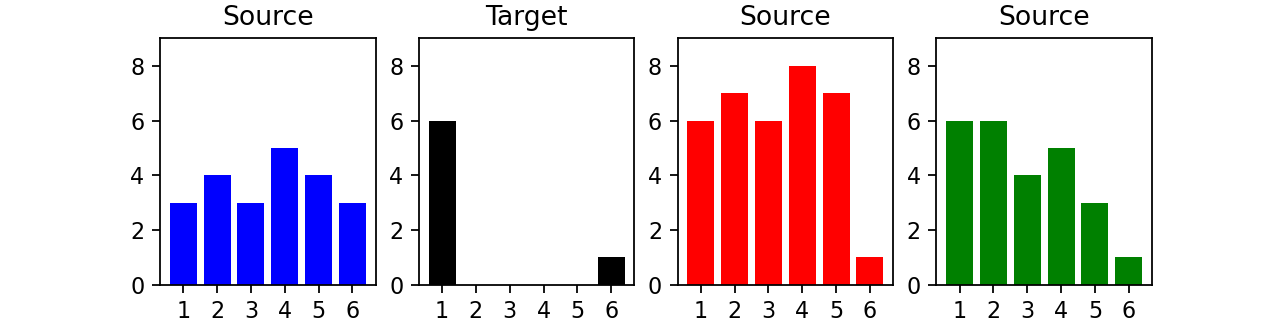

4
[[ 1.  0.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0. -1.  1.  0.]
 [ 0.  0. -1.  1.]
 [ 0.  0.  0. -1.]]
Sum of absolute differences for fully_t is 0.0
Sum of absolute differences for ls_t is 8.881784197001252e-15


In [268]:
# visualizing 1D solutions
s = np.array([3, 4, 3, 5, 4, 3]).T
t = np.array([6, 0, 0, 0, 0, 1]).T

# the expected result
expected_fully_t = np.array([6, 7, 6, 8, 7, 1])
expected_ls_t = np.array([6, 6, 4, 5, 3, 1])

fig, axs = plt.subplots(1,4)
# fig.tight_layout(pad=0.0)
fig.set_size_inches(8,2)
ymax = max(max(s),max(t))+3
width = np.arange(1,len(s)+1)

axs[0].bar(width,s,color='b')
axs[0].set_ylim(0,ymax)
axs[0].set_title('Source')
axs[0].set_xticks(width)

axs[1].bar(width,t,color='k')
axs[1].set_title('Target')
axs[1].set_ylim(0,ymax)
axs[1].set_xticks(width)

fully_t = fully_constrained_1D(s, t)
ls_t = least_squares_1D(s, t)

print(f"Sum of absolute differences for fully_t is {np.sum(np.abs(fully_t-expected_fully_t))}")
print(f"Sum of absolute differences for ls_t is {np.sum(np.abs(ls_t-expected_ls_t))}")

axs[2].bar(width,fully_t,color='r')
axs[2].set_ylim(0,ymax)
axs[2].set_title('Source')
axs[2].set_xticks(width)

axs[3].bar(width,ls_t,color='g')
axs[3].set_ylim(0,ymax)
axs[3].set_title('Source')
axs[3].set_xticks(width)
plt.show()

## Simple 2D Problem - Least Squares

Now we will extend the problem to a simple 2D case, pasting a $2\times2$ region from a $4\times4$ image onto the center of another $4\times4$ image. This problem is identical to the example from lecture but has altered values. We will paste the red-bordered region from the source region onto the red-bordered region in the background image.

![](images/2dsimple.png)

1. First, write out all the constraints on paper, like we did in lecture. How many unknowns are there? How many constraints?
Recall that for a 1D problem with 2 unknowns, we can write the constraint system as follows:
$$
\begin{align}
t_2−t_1 &= s_2−s_1 \\
t_3−t_2 &= s_3−s_2 \\
t_4−t_3 &= s_4−s_3 \\
\end{align}
$$
Where $t_1$ and $t_4$ are known: they are the corresponding values of the background image. You will have one such set of constraints for each row and for each column in your $2\times2$ block of unknown pixel values.

1. Next, convert these equations into standard matrix form.

1. Finally, implement your solution in `least_squares_simple_2D` below as follows:

    1. start by initialize two matrices, `source_im` and `background_im`, as follows:
```python
source_im = np.array([[100, 100, 100, 100],
                          [100, 255, 150, 100],
                          [100, 150, 100, 100],
                          [100, 100, 100, 100]])
background_im = np.array([[10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10]])
```

    1. Now that we are working in 2D, it becomes a bit harder to keep track of which pixels correspond to which elements in our unknown vector. To help keep track of this, create a matrix `im2var` that maps each pixel of interest to a variable number such as: `np.arange(0, 4).reshape(2, 2)`. Then copy this matrix onto the inner region of a $4\times4$ matrix so that accessing a variable number given an `x`, `y` coordinate is simple. We will use these variable numbers to access the correct column in $A$ when adding constraints.

    1. Then initialize matrix $A$ as a sparse matrix using the imported `lil_matrix` (see the [LIL matrix documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) or just type `help(lil_matrix)`) and vector $\mathbf{b}$ to the correct dimensions.

    1. Add constraints to $A$ and $\mathbf{b}$ by considering each row and each column of unknowns one by one. Remember that each row and column lead to a set of constraints (rows in your matrix $A$). For example, we can write the left boundary constraint for the first row as:
```python
A[0, im2var[1, 1]] = 1
b[0] = source_im[1, 1] - source_im[1, 0] + background_im[1, 0]
```

    1. Sparse matrices are best initialized as LIL matrices but perform matrix vector operations better as a CSR matrix. Convert $A$ to a CSR matrix using `A = A.tocsr()` and solve for $\mathbf{v}$ using `v = sla.lsqr(A, b)[0]`. Reshape $\mathbf{v}$ to the correct dimensions and copy its values to a copy of `background_im`. Return a 3-tuple: `source_im, background_im, im_out`.

In [270]:
def least_squares_simple_2D():
    source_im = np.array([[100, 100, 100, 100],
                          [100, 255, 200, 100],
                          [100, 110, 120, 100],
                          [100, 100, 100, 100]])
    background_im = np.array([[10, 10, 10, 10],
                              [10, 10, 10, 10],
                              [10, 10, 10, 10],
                              [10, 10, 10, 10]])
    t = background_im.copy()
    # TODO: your solution here
    
    # making matrix im2var to map pixel of interest
    im2var = np.arange(0,4).reshape(2,2).T
    
    # initializing A as a sparse matrix and vector b
    A = lil_matrix((12, 4))
    b = np.zeros([12])

    # horizontal constraints for b
    count_horizontal = 1
    count_vertical = 1
    iterate_b = 0
    while count_horizontal < 3:
        count_vertical = 1
        weird_count = 0
        while count_vertical < 4:
            if(weird_count == 0):
                b[iterate_b] = source_im[count_horizontal, count_vertical] - source_im[count_horizontal, count_vertical - 1] + background_im[count_horizontal, count_vertical - 1]
                
            if(weird_count == 1):
                b[iterate_b] = source_im[count_horizontal, count_vertical] - source_im[count_horizontal, count_vertical - 1]
                
            if(weird_count == 2):
                b[iterate_b] = -source_im[count_horizontal, count_vertical] + source_im[count_horizontal, count_vertical - 1] + background_im[count_horizontal, count_vertical]
            
            weird_count = weird_count + 1
            iterate_b = iterate_b + 1 
            count_vertical = count_vertical + 1
        
        count_horizontal = count_horizontal + 1
    
    
    count_vertical = 1
    # vertical constraints for b
    while count_vertical < 3:
        count_horizontal = 1
        weird_count = 0
        while count_horizontal < 4:
            if(weird_count == 0):
                A[0, im2var[0, 0]] = 1
                b[iterate_b] = source_im[count_horizontal, count_vertical] - source_im[count_horizontal - 1, count_vertical] + background_im[count_horizontal - 1, count_vertical]
                
            if(weird_count == 1):
                b[iterate_b] = source_im[count_horizontal, count_vertical] - source_im[count_horizontal - 1, count_vertical]
                
            if(weird_count == 2):
                b[iterate_b] = -source_im[count_horizontal, count_vertical] + source_im[count_horizontal - 1, count_vertical] + background_im[count_horizontal, count_vertical]
            
            weird_count = weird_count + 1
            iterate_b = iterate_b + 1 
            count_horizontal = count_horizontal + 1
        
        count_vertical = count_vertical + 1
        
    
    # first row horizontal
    A[0, im2var[0, 0]] = 1
    A[1, im2var[0, 0]] = -1
    A[1, im2var[0, 1]] = 1
    A[2, im2var[0, 1]] = 1
    
    # second row horizontal
    A[3, im2var[1, 0]] = 1
    A[4, im2var[1, 0]] = -1
    A[4, im2var[1, 1]] = 1
    A[5, im2var[1, 1]] = 1

    # first col vertical
    A[6, im2var[0, 0]] = 1
    A[7, im2var[0, 0]] = -1
    A[7, im2var[1, 0]] = 1
    A[8, im2var[1, 0]] = 1
    
    # second col vertical 
    A[9, im2var[0, 1]] = 1
    A[10, im2var[0, 1]] = -1
    A[10, im2var[1, 1]] = 1
    A[11, im2var[1, 1]] = 1
        
    # solving for v
    A = A.tocsr()
    v = sla.lsqr(A, b)[0]
    v = np.reshape(v, (2,2)).T
    
    # copy values of v onto t
    r = 1
    c = 1
    t[r:r+v.shape[0], c:c+v.shape[1]] = v

    return source_im, background_im, t

least_squares_simple_2D()


(array([[100, 100, 100, 100],
        [100, 255, 200, 100],
        [100, 110, 120, 100],
        [100, 100, 100, 100]]),
 array([[10, 10, 10, 10],
        [10, 10, 10, 10],
        [10, 10, 10, 10],
        [10, 10, 10, 10]]),
 array([[ 10,  10,  10,  10],
        [ 10, 164, 110,  10],
        [ 10,  20,  30,  10],
        [ 10,  10,  10,  10]]))

After you have implemented `least_squares_simple_2D`, run it and visualize the results by using `imshow` with optional parameters `cmap='gray', vmin=0, vmax=255`. Give each image a title. Before moving on to the next part of the assignment, visually verify that the result image preserves the *gradient* of the source image without changing any of the background pixels. The expected numerical result is included in the cell below for you to compare to.

<IPython.core.display.Javascript object>


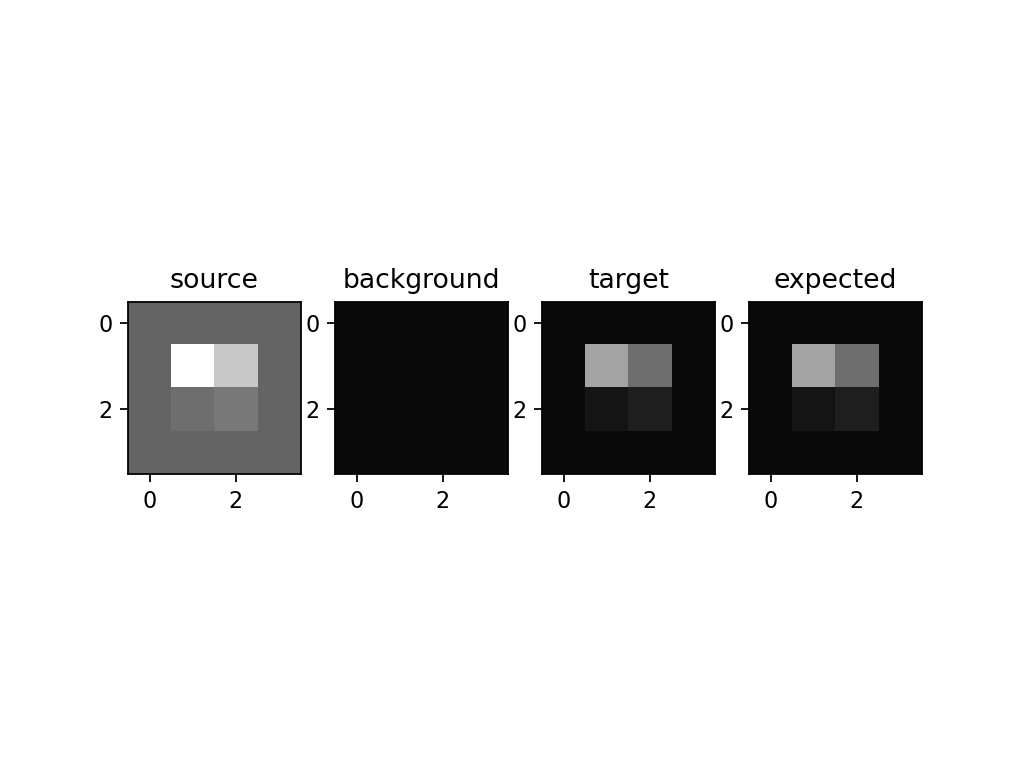

In [271]:
expected = np.array([[ 10,  10,  10,  10],
                     [ 10, 164, 110,  10],
                     [ 10,  20,  30,  10],
                     [ 10,  10,  10,  10]])

source_im, background_im, t = least_squares_simple_2D()

fig, axs = plt.subplots(1,4)
# source image
axs[0].set_title("source")
axs[0].imshow(source_im, cmap='gray', vmin = 0, vmax = 255)

# background image
axs[1].set_title("background")
axs[1].imshow(background_im, cmap='gray', vmin = 0, vmax = 255)

# target image
axs[2].set_title("target")
axs[2].imshow(t, cmap='gray', vmin = 0, vmax = 255)

# expected image
axs[3].set_title("expected")
axs[3].imshow(expected, cmap='gray', vmin = 0, vmax = 255)

plt.show()

## Generalized 2D Problem - Least Squares

Next, we will generalize the 2D problem. You will implement `least_squares_2D`, which takes two parameters, `im_s` and `im_background`, each of which have dimensions $(W + 2) \times (H + 2)$ and returns the interior region (dimensions $W \times H$) of `im_s` pasted onto the interior region of `im_background`. 

Much like in the simple 2D problem, first create a matrix `im2var` to map each pixel of interest to a variable number. Initialize `A` and `b` to the correct dimensions. Remember to initialize `A` as a sparse matrix using `lil_matrix`, or else solving with `sla.lsqr` will take a long time. 

Use a variable `e` as an equation counter. We recommend adding constraints to `A` and `b` in a similar way to the simple 2D problem, by considering each row and column of the block of unknown pixels one by one. You may find it useful to implement helper functions which add an entire column's vertical constraints or an entire row's horizontal constraints to `A`.

Once you have filled `A` and `b` with the constraints, use the imported `time` function to time how long it takes to solve for `v1` using `sla.lsqr`.

```python
t = time.time() # start timer
... # code here
elapsed = time.time() - t # end timer
```

Compare this to how long it would take to instead solve for `v2` by forming the normal equations. Create a dense matrix `ATA = (A.T@A).toarray()` and a dense vector `ATb = A.T@b`, and then solve the dense system $(A^TA)\mathbf{v}_2 = (A^T\mathbf{b})$ using `np.linalg.solve`.

Before starting the timer for each operation, print some descriptive text like `print('Solving sparse system with sla.lsqr')` and `print('Solving dense normal equations')`, then print the elapsed time for each method.

Paste reshaped versions of `v1` and `v2` onto copies of `im_background` and return the resultant images as a 2-tuple: `im_blend1, im_blend2`. 

In [273]:
def add_vertical_constraint(im_s, im_background, im2var, A, b, e, x):
    # x: the column we are on
    # e: the counter that lets us know what constraints we are at
    # horizontal constraints for b
    
    # Top case:subtract the difference compared to the outside boundary + the background's value
    A[e, im2var[1, x]] = 1
    b[e] = im_s[1, x] - im_s[0, x] + im_background[0, x]
    e+=1
    
    # handling the difference equations (look at previous code for pattern)
    for row in range(1, im_s.shape[0]-2):
        A[e, im2var[row,x]] = -1
        A[e, im2var[row+1,x]] = 1
        b[e] = im_s[row + 1, x] - im_s[row, x]
        e += 1
    
    # Bottom case: subtract the difference compared to the outside boundary + the background's value
    A[e, im2var[im_s.shape[0]-1, x]] = 1
    b[e] = im_s[im_s.shape[0]-1, x] - im_s[im_s.shape[0]-2, x] + im_background[im_s.shape[0]-2, x]
    e+=1

    return e     
    
def add_horizontal_constraint(im_s, im_background, im2var, A, b, e, y):
    #
    # TODO: your code here
    #
          
    # Same concept here
    # Handling left boundary
    A[e, im2var[y, 1]] = 1
    b[e] = im_s[y, 1] - im_s[y, 0] + im_background[y, 0]
    e+=1
          
    # Handling the differenc equations
    for col in range(1,im_s.shape[1]-2):
        A[e, im2var[y, col]] = -1
        A[e, im2var[y, col+1]] = 1
        b[e] = im_s[y, col+1] - im_s[y, col]
        e+=1
        
    # Handling the right boundary   
    A[e, im2var[y, im_s.shape[1]-1]] = 1
    b[e] = im_s[y, im_s.shape[1]-1] - im_s[y, im_s.shape[1]-2] + im_background[y, im_s.shape[1]-2]
    e+=1

    return e

# generalized 2D
def least_squares_2D(im_s, im_background, do_normal=True):
    # im_s : the source image 
    # ims_background : the background image
    # initialize results to just be copies of the background
    # if do_normal == False, skip doing the more expensive normal equation solve
    im_blend1 = im_background.copy()
    im_blend2 = im_background.copy()
    
    #
    # TODO: your code here
    #
          
    # exterior region is in h x w dimension
    h_ex, w_ex = im_blend1.shape
    h, w = im_blend1.shape

    # interior region is h-2 x w-2 dimension, so we reshape h-2, w-2 to easily find the coordinates
    h_in = h_ex - 2
    w_in = w_ex - 2
    
    # interior region is h-2 x w-2 dimension, so we reshape h-2, w-2
    # example: 4x4 background; 2x2 source image
    # we reshape 
    im2var = np.zeros((h_ex,w_ex), dtype = int)
    im2var[1:-1, 1:-1] = np.arange((h_in)*(w_in)).reshape((h_in),(w_in))
    
    # initializing A as a sparse matrix and vector b
    # col: unknown constraints: the im_s dimension being pasted into background
    # row: all the boundaries and in betweens constraints
    A = lil_matrix((2*(h-1)*(w-1), (h_in)*(w_in)))
    b = np.zeros([2*(h-1)*(w-1)])
    e = 0 
          
    # top of A matrix: row constraints, bottom of A matrix: column constraints
    for row in range(1,h):
        e = add_horizontal_constraint(im_s,im_background, im2var, A, b, e, row)
          
    for col in range(1,w):
        e = add_vertical_constraint(im_s,im_background, im2var, A, b, e, col)
    

    A = A.tocsr()
    
    # time for sparse blend
    print('Solving sparse system with sla.lsqr')
    t1 = time.time()
    # Solving with sla.lsqr and refitting it into the background
    unknowns_sparse = sla.lsqr(A, b)[0]
    unknowns_sparse = unknowns_sparse.reshape((h_in),(w_in))
    elapsed = time.time() - t1
    print("Elapsed time using sla.lsqr", elapsed)
    # incorporating the picture: changing the image from one index from the front to one index from the back
    im_blend1[1:-1,1:-1] = unknowns_sparse
    
    if do_normal == True:
        # otherwise, don't do dense normal equations
        # time for dense normal blend
        print('Solving dense normal equations')
        t2 = time.time()

        # Solving with normal equation and refitting it into the background
        ATA = (A.T@A).toarray()
        ATb = A.T@b
        unknowns_dense = np.linalg.solve(ATA, ATb)
        unknowns_dense = unknowns_dense.reshape((h_in),(w_in))
        elapsed = time.time() - t2
        print("Elapsed time using normal equations, elapsed")
        # incorporating the picture: changing the image from one index from the front to one index from the back
        im_blend2[1:-1,1:-1] = unknowns_dense
          
          
    return im_blend1, im_blend2

Load `toyim = plt.imread('images/toy_problem.png')`. Create `im_background` by creating a matrix with the same dimensions as `toyim` filled with the value at the top left corner of `toyim` using np.full [see numpy.full documentation](https://numpy.org/doc/stable/reference/generated/numpy.full.html). 

We will test `least_squares_2D` by reconstructing `toyim`. Run `least_squares_2D` on `toyim` and `im_background`, and display the two reconstructed images with titles. Again, make sure to pass `imshow` the optional parameter `cmap = 'gray'`. 

Additionally, give the error value between your reconstructed image(either) and the original image as a printed statement (using `np.linalg.norm` may be of use).

Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.1696610450744629
Solving dense normal equations
Elapsed time using normal equations, elapsed


<IPython.core.display.Javascript object>


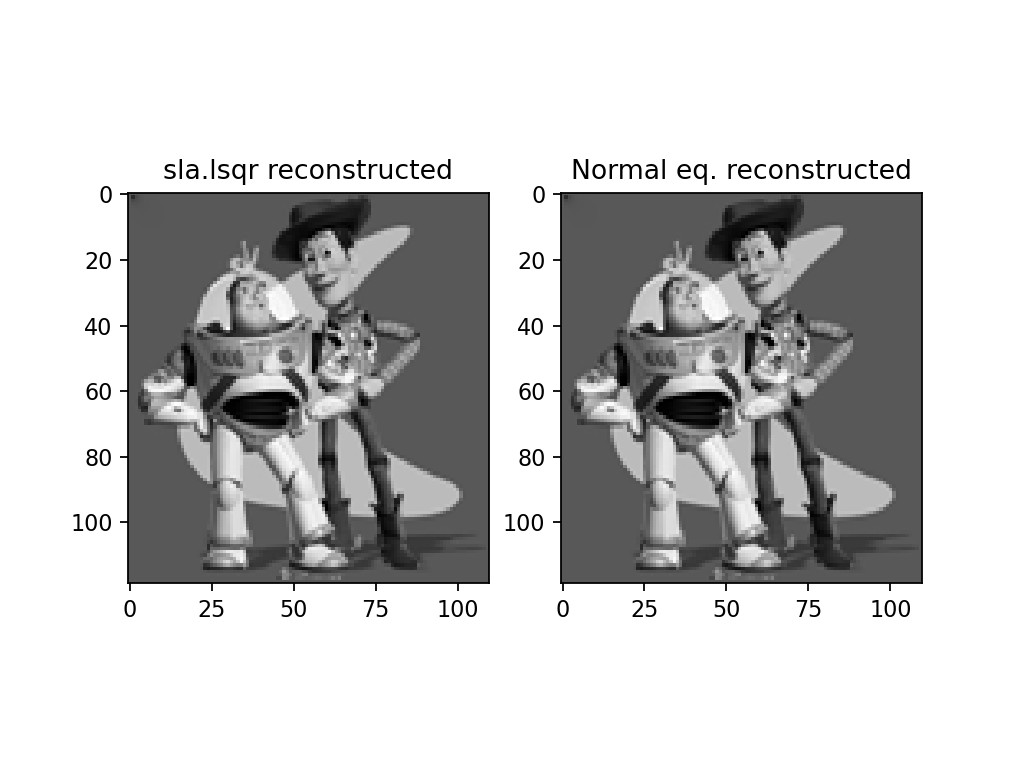

Sum of absolute differences is 0.04364013671875


In [274]:
toyim = plt.imread('images/toy_problem.png')
im_background = np.full(toyim.shape, toyim[0,0])
im_blend1, im_blend2 = least_squares_2D(toyim, im_background)

fig1, axs1 = plt.subplots(1,2)

# Reconstructed image with least square method
axs1[0].set_title("sla.lsqr reconstructed")
axs1[0].imshow(im_blend1,cmap='gray')

# Reconstructed image with normal equation
axs1[1].set_title("Normal eq. reconstructed")
axs1[1].imshow(im_blend2,cmap='gray')

# Finds the error after normalizing
print(f"Sum of absolute differences is {np.sum(np.abs(np.linalg.norm(im_blend1)-np.linalg.norm(toyim)))}")

## Poisson Blending

For Poisson Blending, you will select a coordinate on the background image which will serve as the bottom right corner for an object image to be blended into the background image. Ideally, the background of the object image and the surrounding area of the target region will be of similar color. First, run the following cell and select the coordinates for the gradient blend by clicking on the interactive figure. The interactive figure should draw a rectangle where the object image will appear in the blended image.

<IPython.core.display.Javascript object>


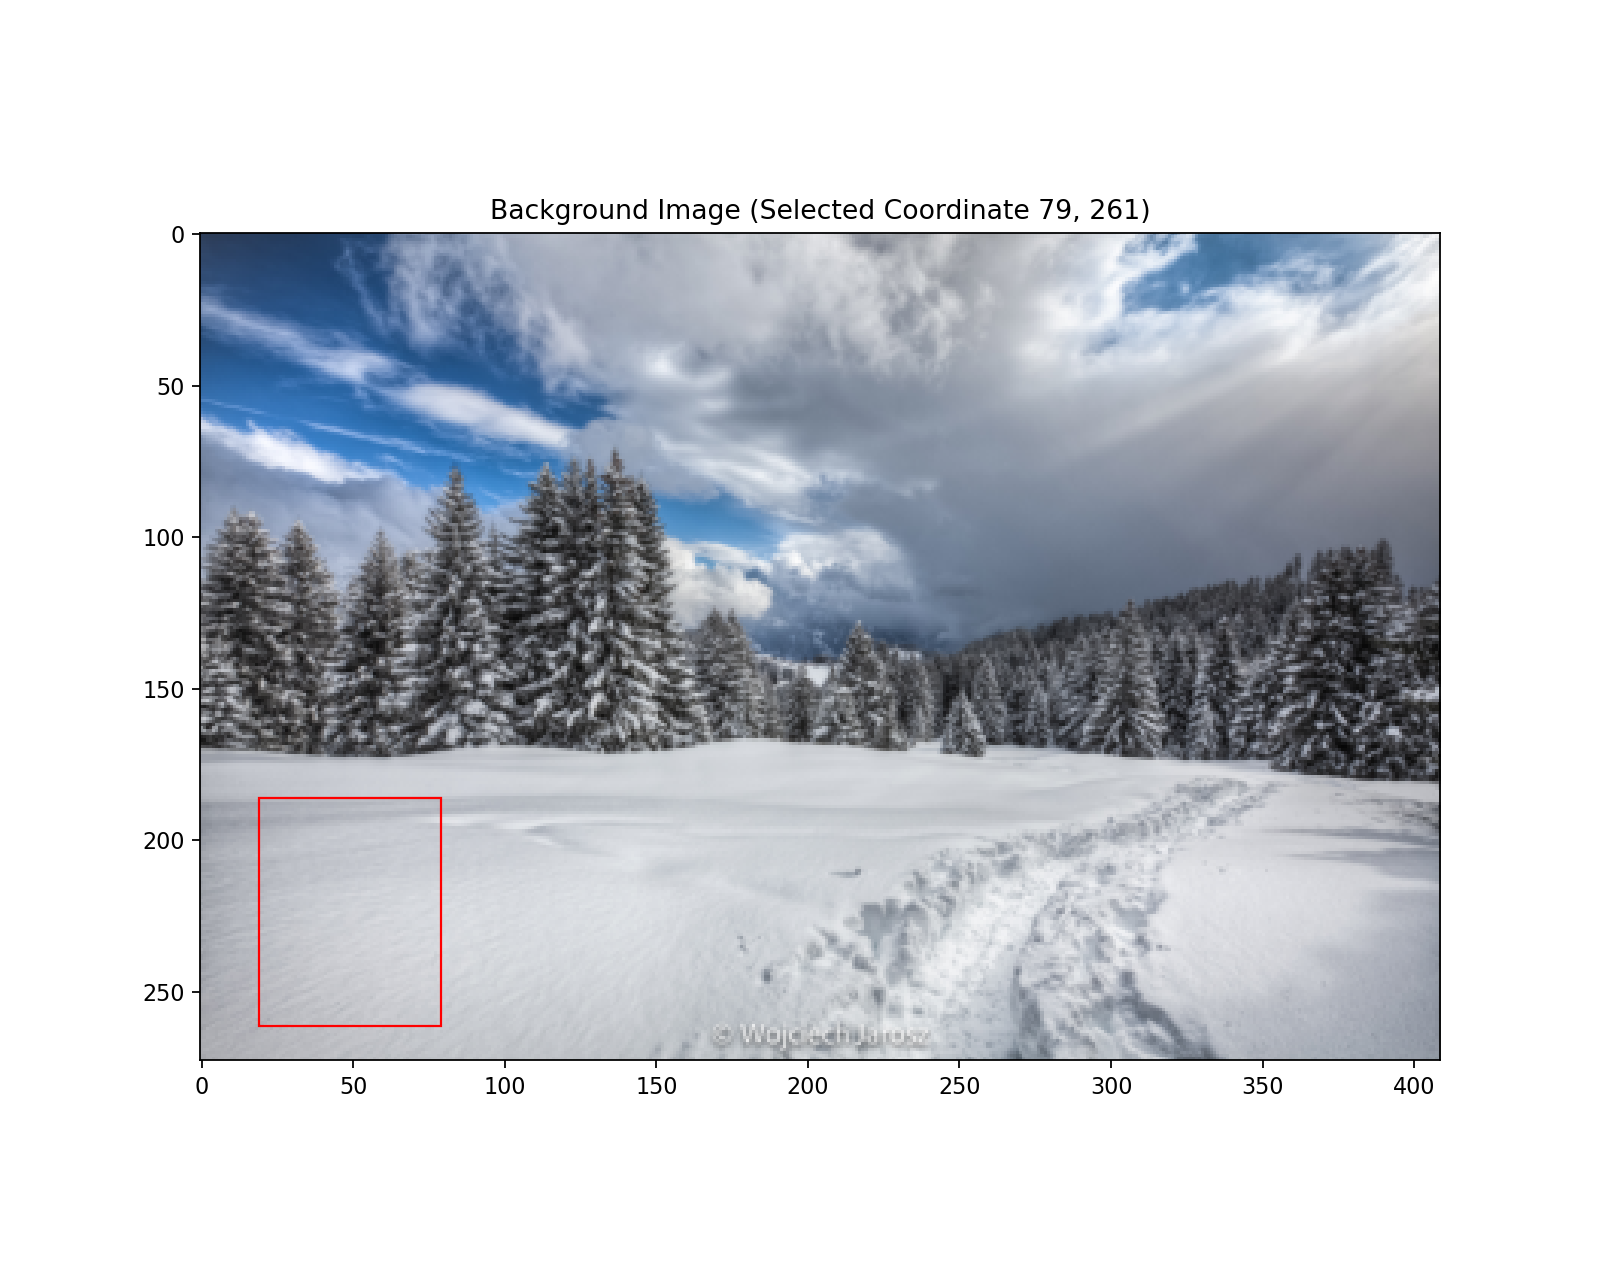

In [275]:
## new gradient domain copy-paste code should go here
# read in background and object images
im_background = plt.imread('images/background.jpg')/255.0
im_object = plt.imread('images/penguin-chick.jpg')/255.0
#
# reduce the size of the image for faster performance while debugging
# You can comment these two lines out to use the full-resolution images
im_background = resize(im_background, (im_background.shape[0] // 5,
                                       im_background.shape[1] // 5),
                       anti_aliasing=True)
im_object = resize(im_object, (im_object.shape[0] // 5,
                               im_object.shape[1] // 5),
                       anti_aliasing=True)


# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.zeros(2)

# handling coordinate selection by storing selected coordinates
def onclick(event):
    global coords, objh, objw
    coords = np.round([event.xdata, event.ydata]).astype(np.int)
    plt.title(f"Background Image (Selected Coordinate {coords[0]}, {coords[1]})")
    # draw rectangle on image
    rect = Rectangle((event.xdata-objw,event.ydata-objh),objw,objh,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)

# display interactive figure for selecting coordinate in background image
fig = plt.figure()
fig.set_size_inches(10,8)
plt.imshow(im_background)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Background Image (Click a place to blend object image)")
plt.show()

Below, we provide you `simple_copy_paste` which simply copies the pixel values from `im_object` onto the appropriate location of `im_background`.

You task is to implement `poisson_copy_paste` which takes three parameters: `coords`, the coordinates of the bottom right corner of the region to blend, `im_object`, the image to paste into the background image, and `im_background`, the unaltered background image. 

Cut out the appropriate region of `im_background` and solve for all three channels of the blended region using `least_squares_2D`. Paste the results back into the appropriate region of a copy of `im_background`. Return a tuple of two images, one from solving with the `sla.lsqr` and the other from solving with the normal equations.

In [276]:
def simple_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape
    
    # paste pixel values into im_background
    result = im_background.copy()
    result[y-objh:y, x-objw:x, :] = im_object
    
    return result

def poisson_copy_paste(coords, im_object, im_background, do_normal=True):
    # pass do_normal to least_squares_2d
    x, y = coords
    objh, objw, _ = im_object.shape

    res1 = im_background.copy()
    res2 = im_background.copy()
    #
    # TODO: your code here

    # Cutting out the region
    r_background = im_background[y-objh:y,x-objw:x,0]
    g_background = im_background[y-objh:y,x-objw:x,1]
    b_background = im_background[y-objh:y,x-objw:x,2]
    
    # Getting the three color channels of the object
    r_object = im_object[:,:,0]
    g_object = im_object[:,:,1]
    b_object = im_object[:,:,2]
    
    # Blending with least_squares_2D
    print("Blending red")
    r_blend_lsqr, r_blend_norm = least_squares_2D(r_object, r_background,do_normal)
    print("Blending green")
    g_blend_lsqr, g_blend_norm = least_squares_2D(g_object, g_background,do_normal)
    print("Bleding blue")
    b_blend_lsqr, b_blend_norm = least_squares_2D(b_object, b_background,do_normal)
    
    res1[y-objh:y,x-objw:x,0] = r_blend_lsqr
    res1[y-objh:y,x-objw:x,1] = g_blend_lsqr
    res1[y-objh:y,x-objw:x,2] = b_blend_lsqr
    
    res2[y-objh:y,x-objw:x,0] = r_blend_norm
    res2[y-objh:y,x-objw:x,1] = g_blend_norm
    res2[y-objh:y,x-objw:x,2] = b_blend_norm

    
    return res1, res2


Run `poisson_copy_paste` and display your two blended images. If implemented correctly, print statements from the code should appear detailing the progress and time needed to execute least squares. You might need to restrict the blended image values to between 0 and 1 by calling `.clip(0,1)` on your blended images.

<IPython.core.display.Javascript object>


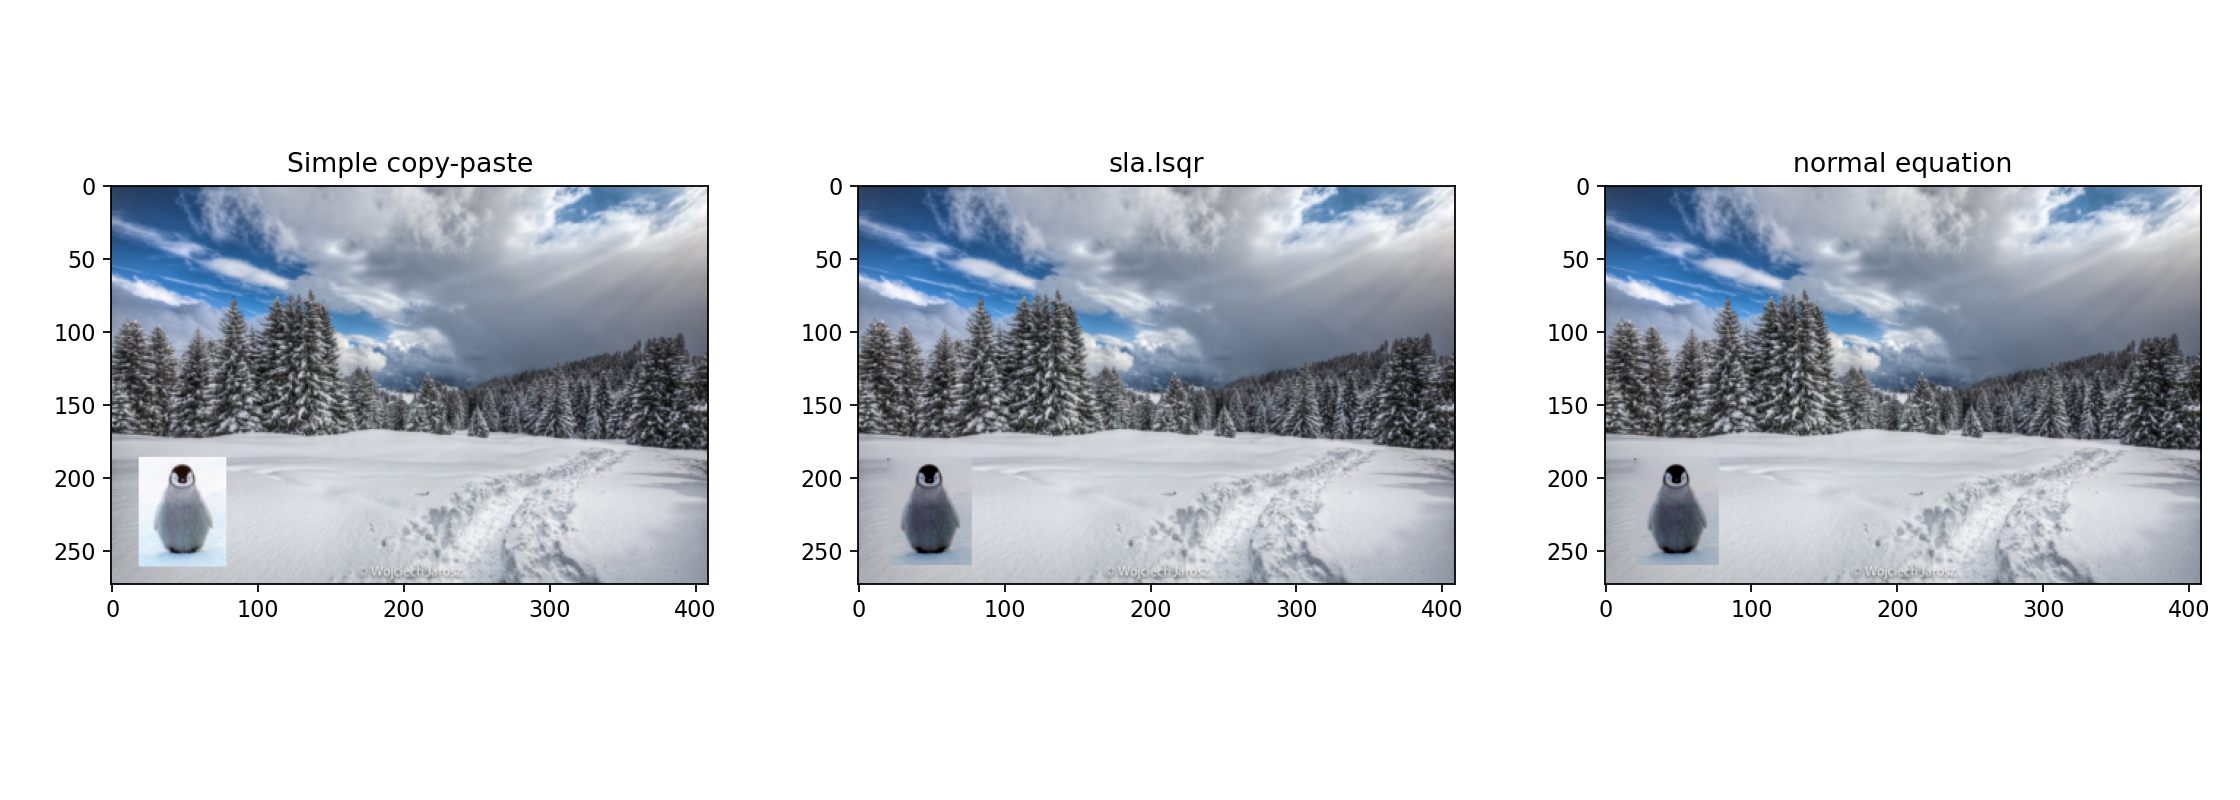

Blending red
Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.06757187843322754
Solving dense normal equations
Elapsed time using normal equations, elapsed
Blending green
Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.06046581268310547
Solving dense normal equations
Elapsed time using normal equations, elapsed
Bleding blue
Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.06796598434448242
Solving dense normal equations
Elapsed time using normal equations, elapsed


In [277]:
res0 = simple_copy_paste(coords, im_object, im_background)

fig3, axs3 = plt.subplots(1,3)
fig3.tight_layout(pad=0.0)
fig3.set_size_inches(14,5)

# show simple copy-paste first
axs3[0].imshow(res0.clip(0, 1))
axs3[0].set_title("Simple copy-paste")

#
# TODO: your code here
# add two more sub-plots with your poisson copy-paste results
#
# sla.lsqr blending
res1, res2 = poisson_copy_paste(coords, im_object, im_background)
axs3[1].imshow(res1.clip(0, 1))
axs3[1].set_title("sla.lsqr")

# normal equation blending
axs3[2].imshow(res2.clip(0, 1))
axs3[2].set_title("normal equation")
plt.show()

## Your Poisson Blending
Now blend two images of your choice using `poisson_copy_paste`. Change the images used in the code blocks above, and comment out the default images, which should look something like this:

```python
#im_background = plt.imread('images/background.jpg')/255.0
#im_object = plt.imread('images/penguin-chick.jpg')/255.0
im_background = plt.imread('images/your_background.jpg')/255.0
im_object = plt.imread('images/your_object.jpg')/255.0
```

Be creative! The best results will be shown in class and may be given extra credit. **Submit the source and target images you use as well as the blended result.**

<IPython.core.display.Javascript object>


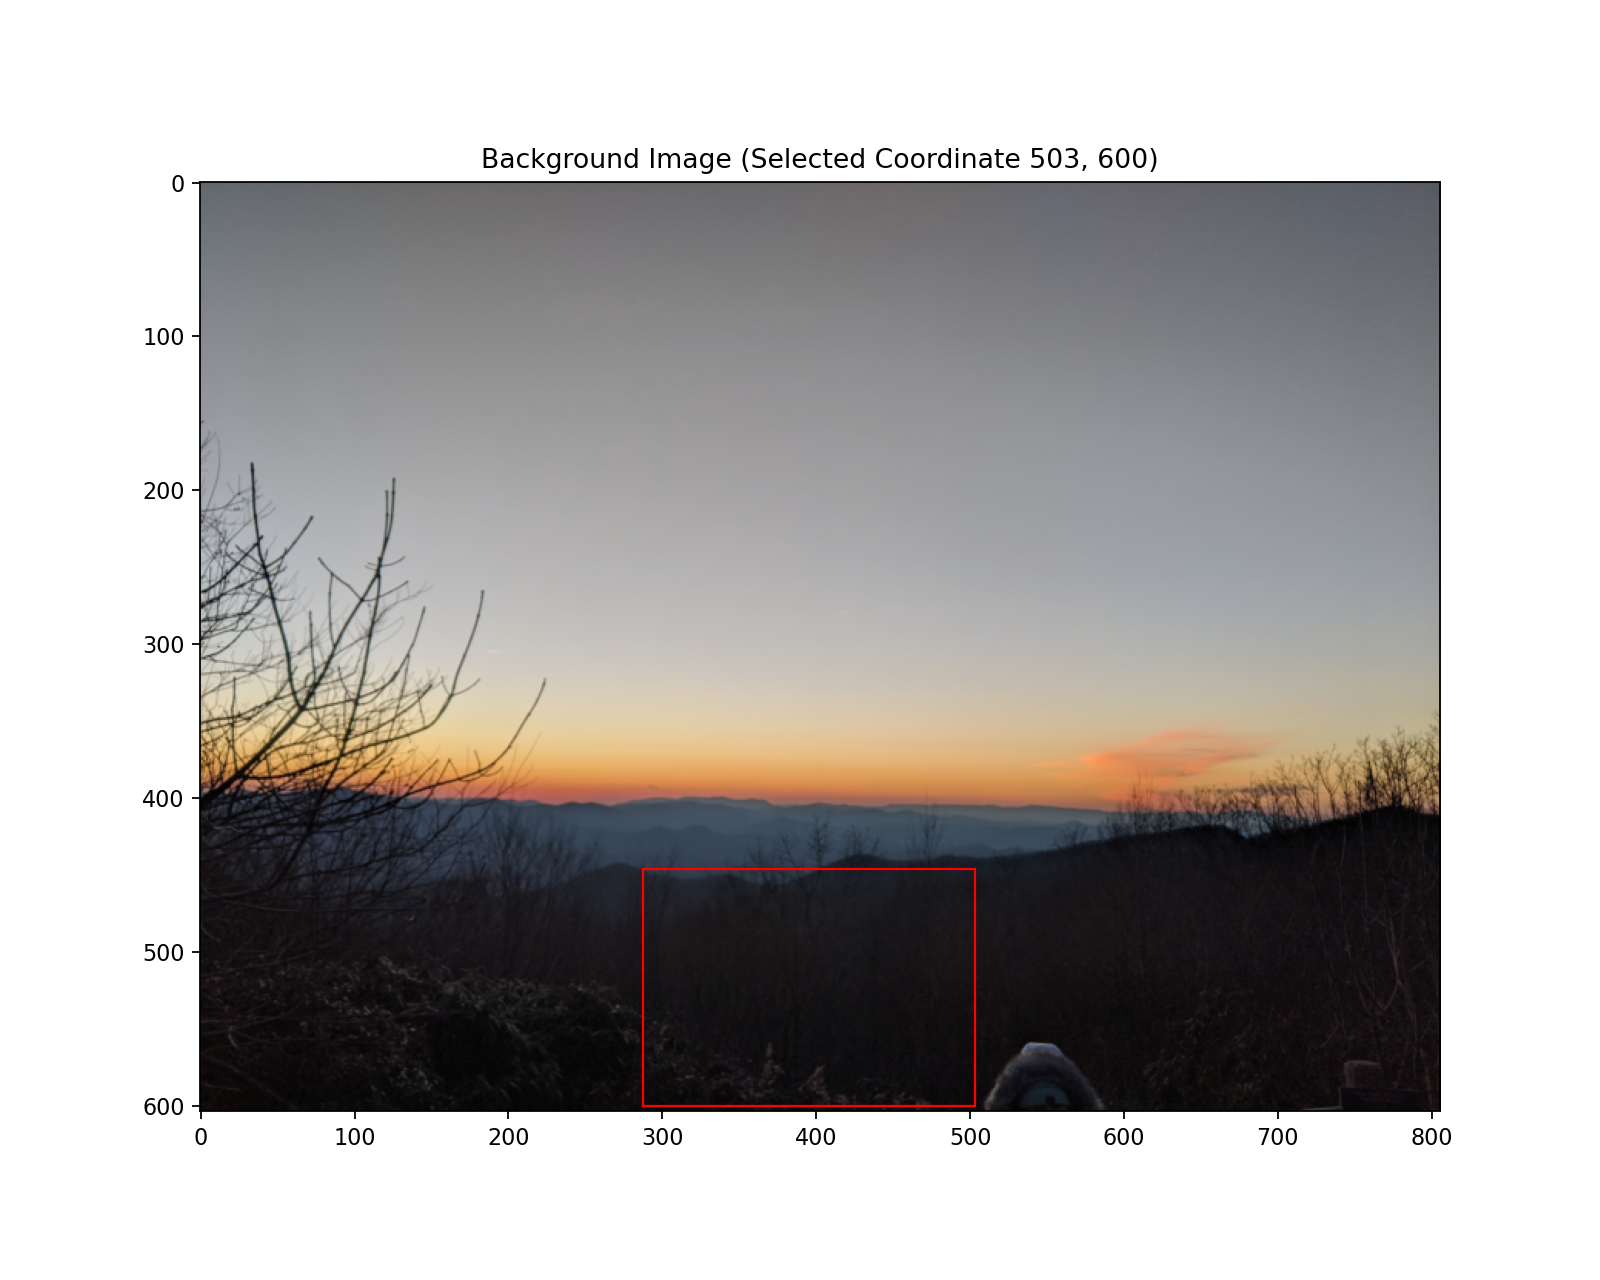

In [280]:
## new gradient domain copy-paste code should go here
# read in background and object images
im_background = plt.imread('images/immacry.jpg')/255.0
im_object = plt.imread('images/todo.jpg')/255.0
#
# reduce the size of the image for faster performance while debugging
# You can comment these two lines out to use the full-resolution images
im_background = resize(im_background, (im_background.shape[0] // 5,
                                       im_background.shape[1] // 5),
                       anti_aliasing=True)
im_object = resize(im_object, (im_object.shape[0] // 5,
                               im_object.shape[1] // 5),
                       anti_aliasing=True)
#
#


# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.zeros(2)

# handling coordinate selection by storing selected coordinates
def onclick(event):
    global coords, objh, objw
    coords = np.round([event.xdata, event.ydata]).astype(np.int)
    plt.title(f"Background Image (Selected Coordinate {coords[0]}, {coords[1]})")
    # draw rectangle on image
    rect = Rectangle((event.xdata-objw,event.ydata-objh),objw,objh,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)

# display interactive figure for selecting coordinate in background image
fig = plt.figure()
fig.set_size_inches(10,8)
plt.imshow(im_background)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Background Image (Click a place to blend object image)")
plt.show()

<IPython.core.display.Javascript object>


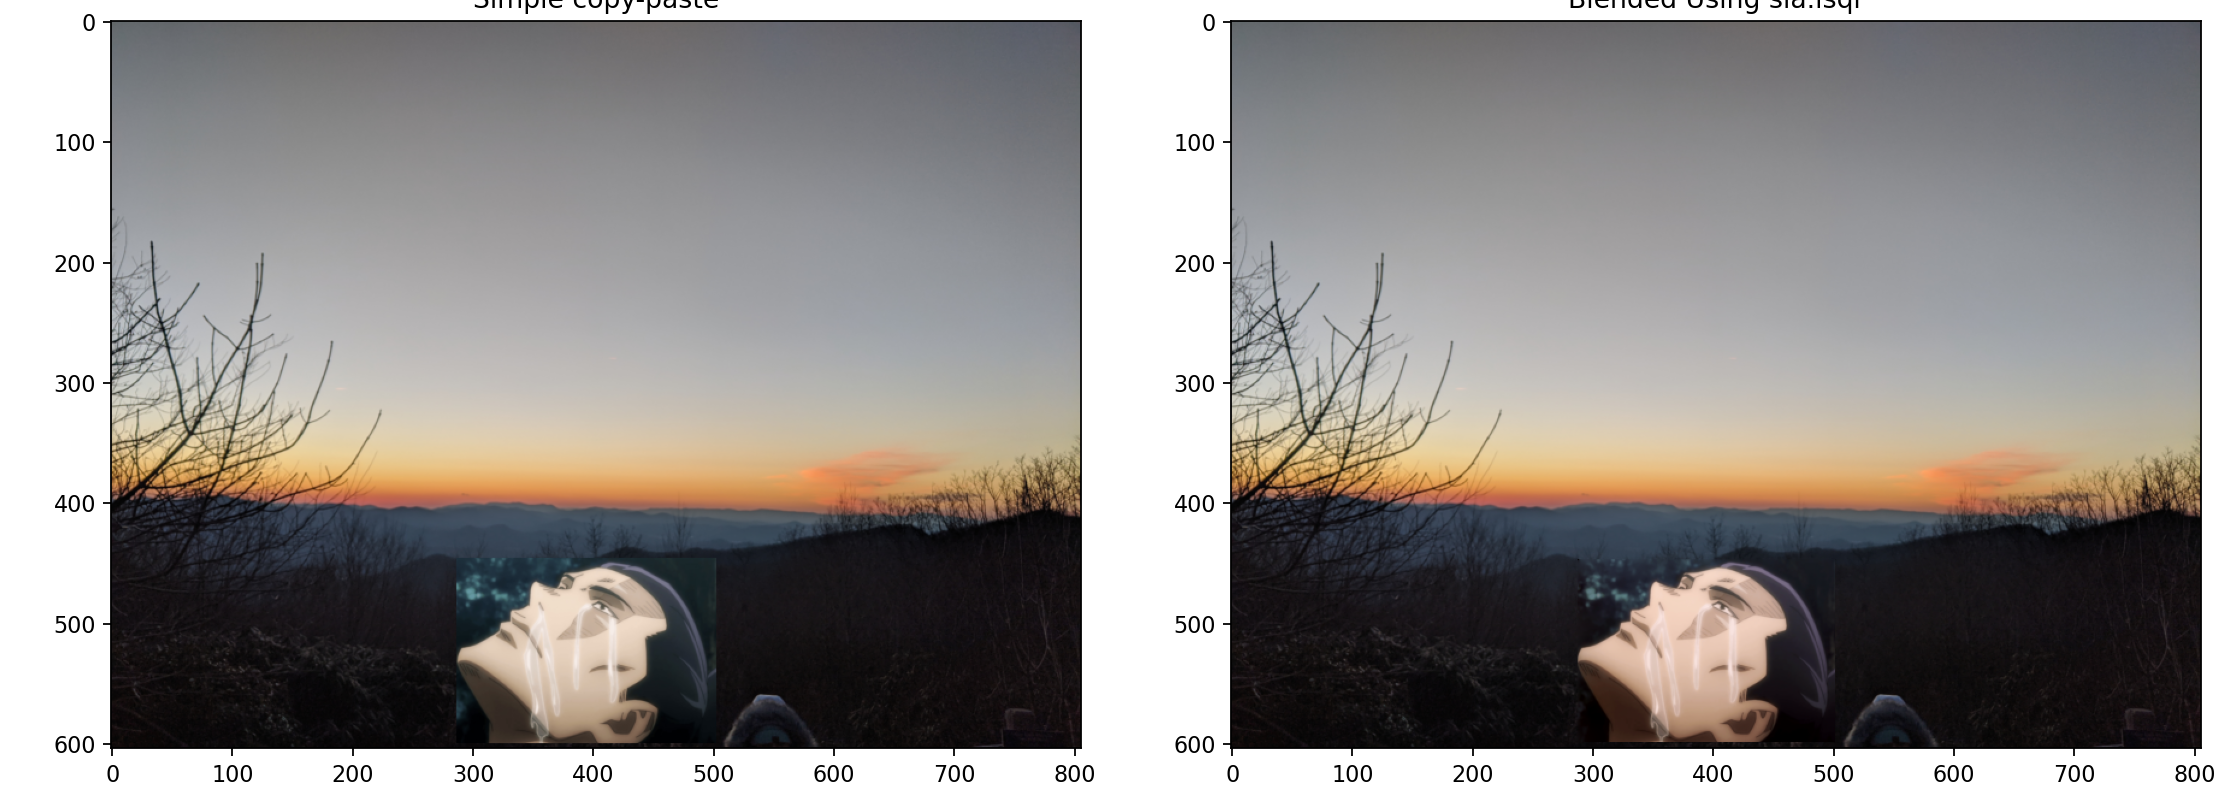

Blending red
Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.6010558605194092
Blending green
Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.6033627986907959
Bleding blue
Solving sparse system with sla.lsqr
Elapsed time using sla.lsqr 0.5375521183013916


In [281]:
res0 = simple_copy_paste(coords, im_object, im_background)

fig4, axs4 = plt.subplots(1,2)
fig4.tight_layout(pad=0.0)
fig4.set_size_inches(14,5)

# show simple copy-paste first
axs4[0].imshow(res0.clip(0, 1))
axs4[0].set_title("Simple copy-paste")

#
# TODO: your code here
# add two more sub-plots with your poisson copy-paste results
#

# Reconstructed image using sla.lsqr
res1, res2 = poisson_copy_paste(coords, im_object, im_background, False)
axs4[1].imshow(res1.clip(0, 1))
axs4[1].set_title("Blended Using sla.lsqr")

plt.show()

## Submitting your work

Before handing in via Canvas, make sure:
  * your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.
  * you've included any scans/images that your notebook references.
  * you've renamed the provided notebook according to your name and netid as: **[YourFirstName]\_[YourLastName]\_[YourNetId]\_[Assignment].ipynb**. For example, if John Doe has netid **F00237S**, his submission filename for PA1 should be **John_Doe_F00237S_PA1.ipynb**.
  
## References
This assignment is based off of a [similar one](http://graphics.cs.cmu.edu/courses/15-463/2010_fall/hw/proj2g/) from CMU.